In [2]:
import os
import json
from pathlib import Path

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import as_strided
from matplotlib import colors

for dirname, _, filenames in os.walk('arc'):
    print(dirname)

arc
arc/evaluation
arc/test
arc/training


In [4]:
from utils import training_path
from utils import training_tasks, evaluation_tasks, test_tasks
from utils import cmap, norm
from utils import nth_sample
from utils import load_and_plot, plot_one_ax
from utils import plot_task, plot_pred_and_target, just_plot

In [8]:
from dsl import (
    crop_to_content_unlifted, group_by_color_unlifted, negative_by_max_color_unlifted, negative_by_most_frequent_color_unlifted
)

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
print(len(training_tasks), len(evaluation_tasks), len(test_tasks))

400 400 100


## Solving manually all tasks with the 'crop' pattern (and some others)

### Insights

- Break solutions in composable functions. For example, the solution to Task 746b3537.
  - The idea is to select the row or the column based in the color homogeinity.
  - I solved directly, but the solution could be composed of functions or be constructed by trial and error. Look there for insightful comments.
  - See the new solution there.

# Just crop

## Task 30 [1cf80156]

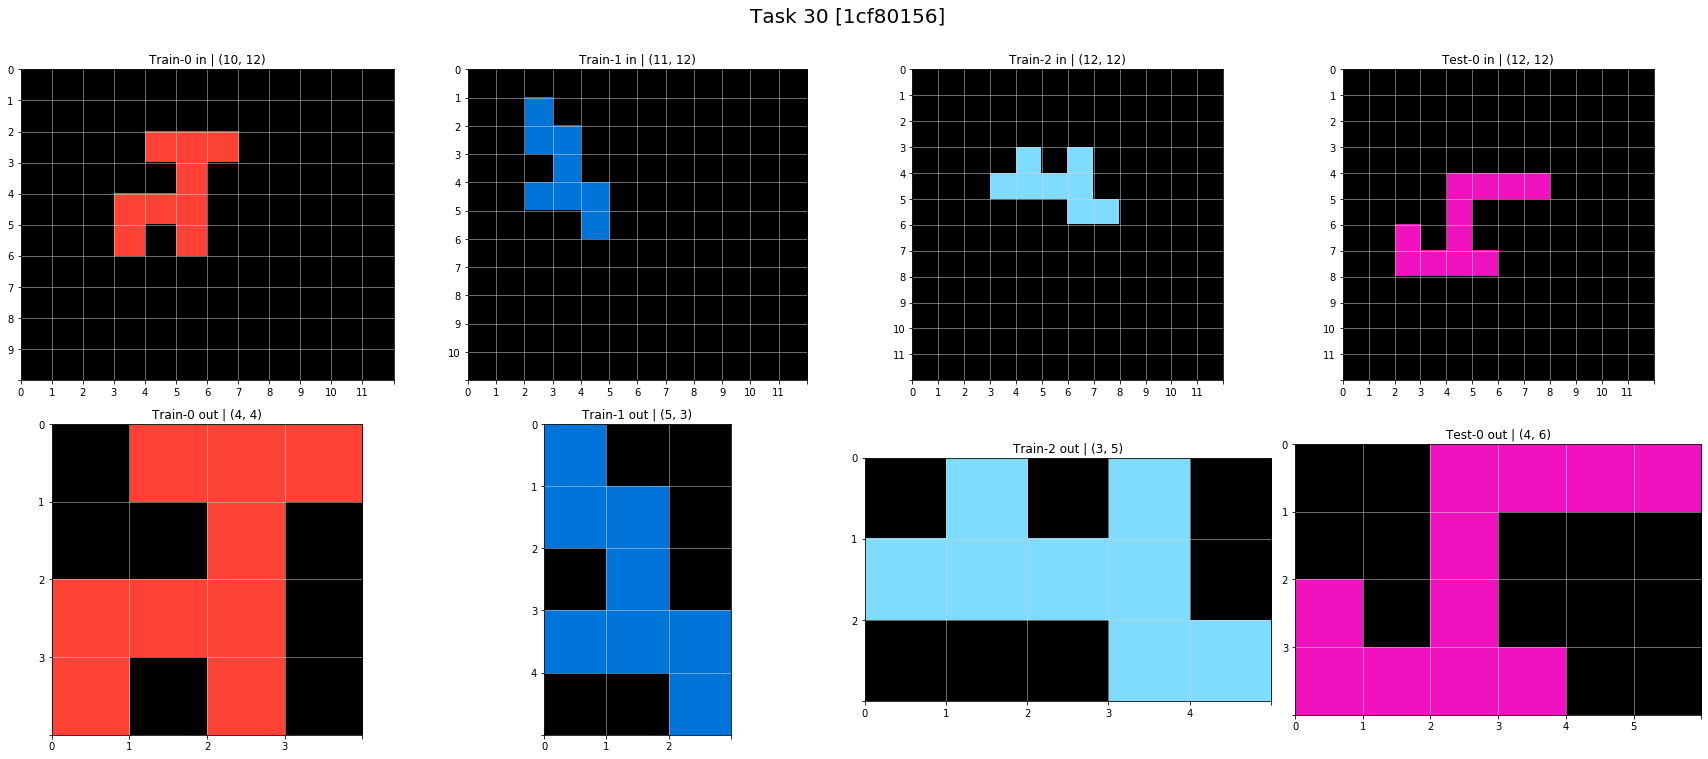

In [25]:
fname = '1cf80156.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid)

In [17]:
task = task['train']

In [36]:
pixmap_in, pixmap_out = nth_sample(task, 0)

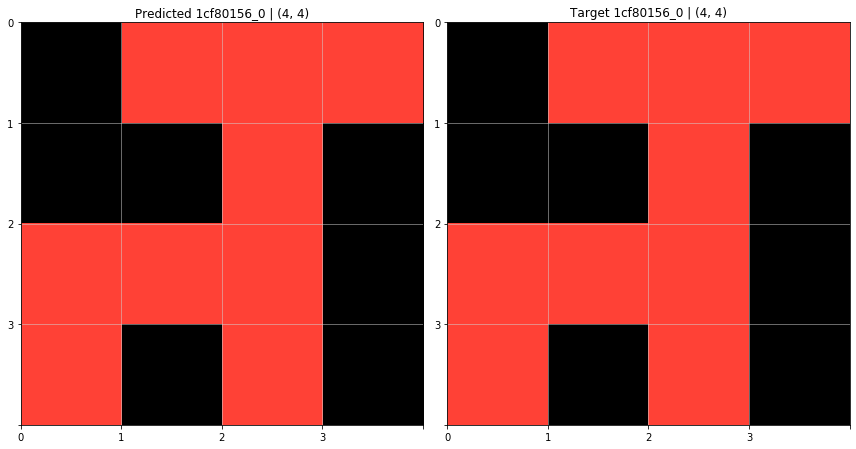

In [40]:
pred = crop_to_content_unlifted(pixmap_in)
plot_pred_and_target(pred, pixmap_out, fname[:-5] + '_0')

# Pattern repetition 

## Fractal repetition

### Task 216 [8f2ea7aa]

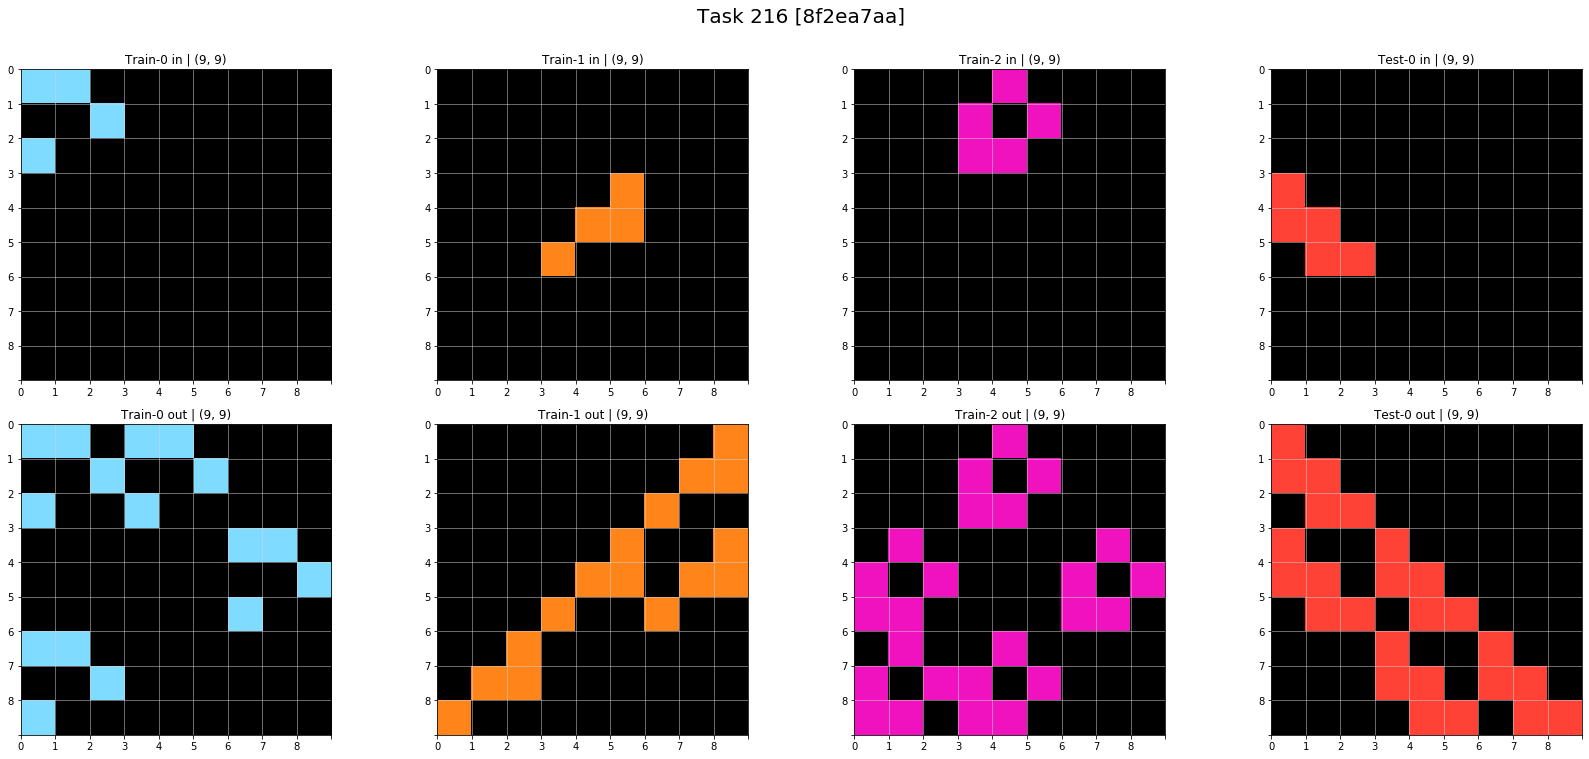

In [26]:
fname = '8f2ea7aa.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid)

In [310]:


def fractal_repetition(pixmap):
    """
    Maps each pixel in the pattern to a
    window with pattern shape in the output pixmap.
    """

    # TODO: maybe won't work if pattern.shape ** 2 != pixmap.shape

    pixm_sh = pixmap.shape

    # Crop code (ideally, called before this method)
    pattern = crop_to_content_unlifted(pixmap)
    ptrn_sh = pattern.shape

    # Fractal repetition code
    out_sh = (pixm_sh[0] // ptrn_sh[0], pixm_sh[1] // ptrn_sh[1])
    output = np.tile(pattern, out_sh)
    xs, ys = np.indices(pixmap.shape, dtype=np.int8)
    # rationale: break pixmap in pattern shape, each block being pattern shape
    shape = out_sh + ptrn_sh
    strides = (pixm_sh[1] * ptrn_sh[0],  # bytes to next vertical block
               ptrn_sh[1],               # bytes to next horizontal block
               pixm_sh[1],               # bytes to next vertical element
               1)                        # bytes to next horizontal element
    # if pattern_shape is (3, 3),
    # then reshape gives n pattern blocks fitting pixmap
    reshape = (out_sh[0] * out_sh[1],) + ptrn_sh

    # block indices (this can be a util func?)
    xs_strided = as_strided(xs, shape=shape, strides=strides).reshape(*reshape)
    ys_strided = as_strided(ys, shape=shape, strides=strides).reshape(*reshape)

    # repeat pattern
    for i in range(reshape[0]):  # num of blocks in pixmap
        pixel = pattern[i // pattern.shape[0], i % pattern.shape[0]]
        output[xs_strided[i], ys_strided[i]] = pattern * (pixel != 0)

    return output

In [42]:
task = task['train']

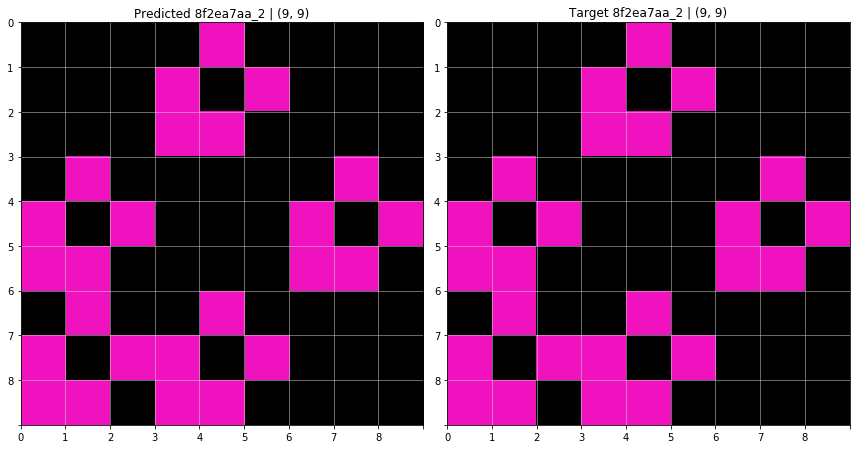

In [313]:
sample_id = 2
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = fractal_repetition(pixmap_in)
plot_pred_and_target(pred, pixmap_out, fname[:-5] + f'_{sample_id}')

## Normal repetition

### Task 56 [28bf18c6 ]

- Patterns: crop, pattern repetition.
- Solved with `fractal_repetition` from task 56 (8ef2ea7aa).
  - Mostly because `pixmap.shape` restricts output shape.

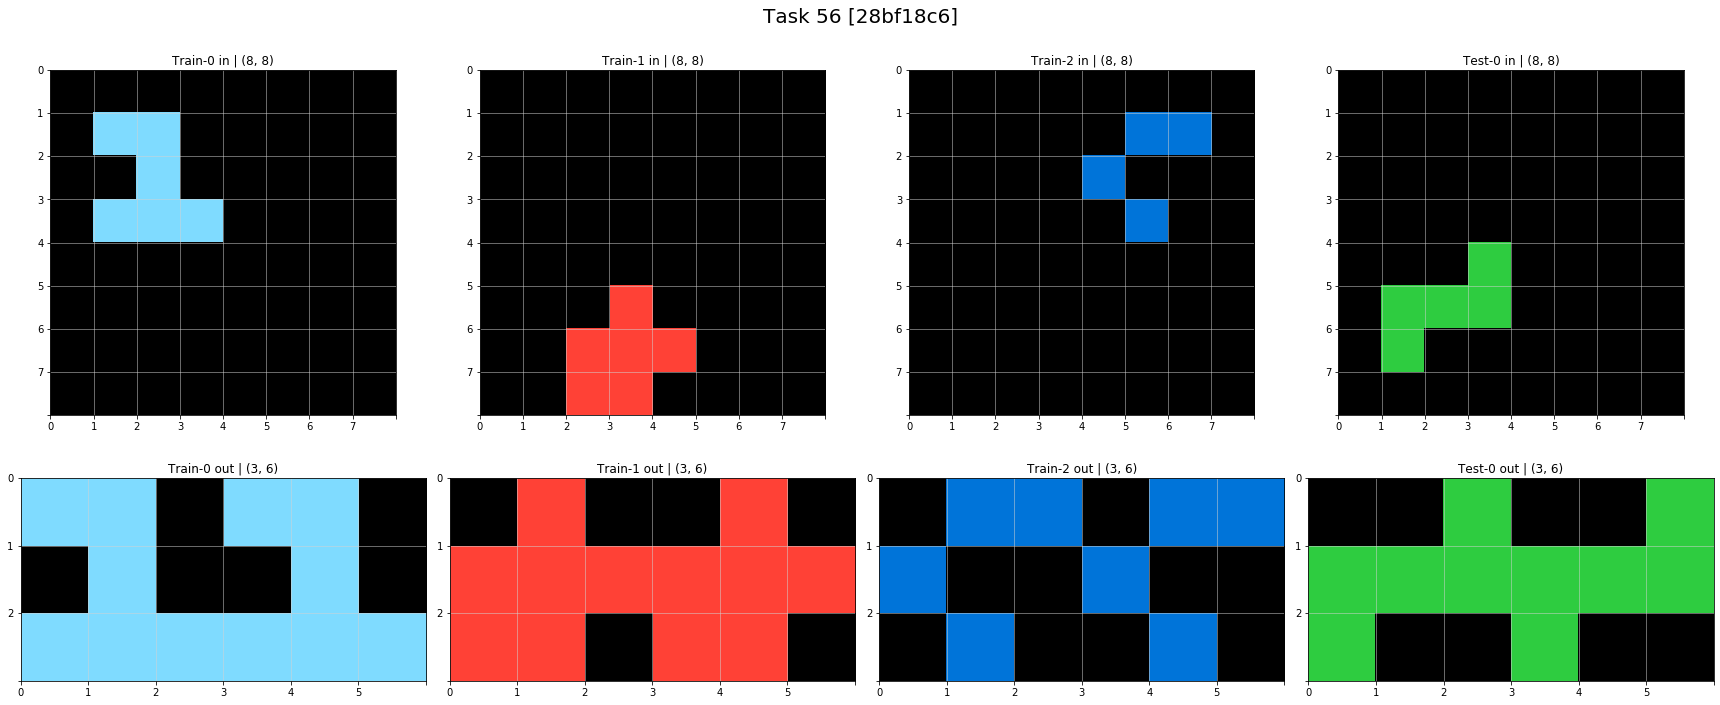

In [24]:
fname = '28bf18c6.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid)

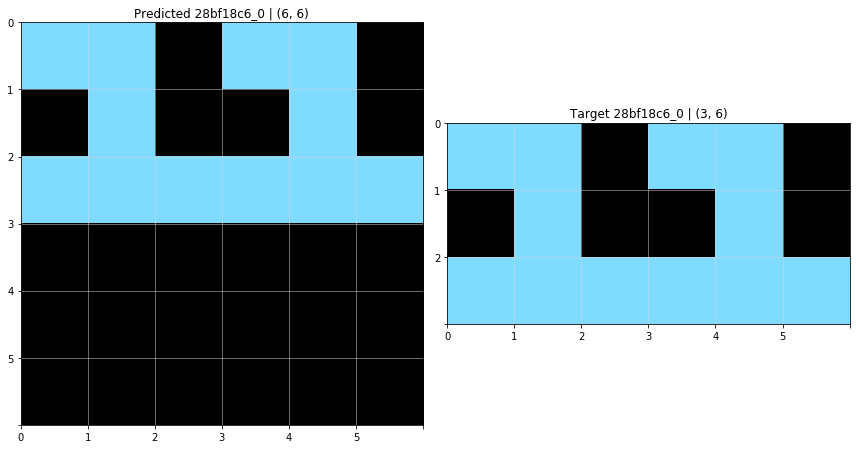

In [942]:
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = fractal_repetition(pixmap_in)
plot_pred_and_target(pred, pixmap_out, fname[:-5] + f'_{sample_id}')

# Image reflection

## Task 176 [7468f01a]

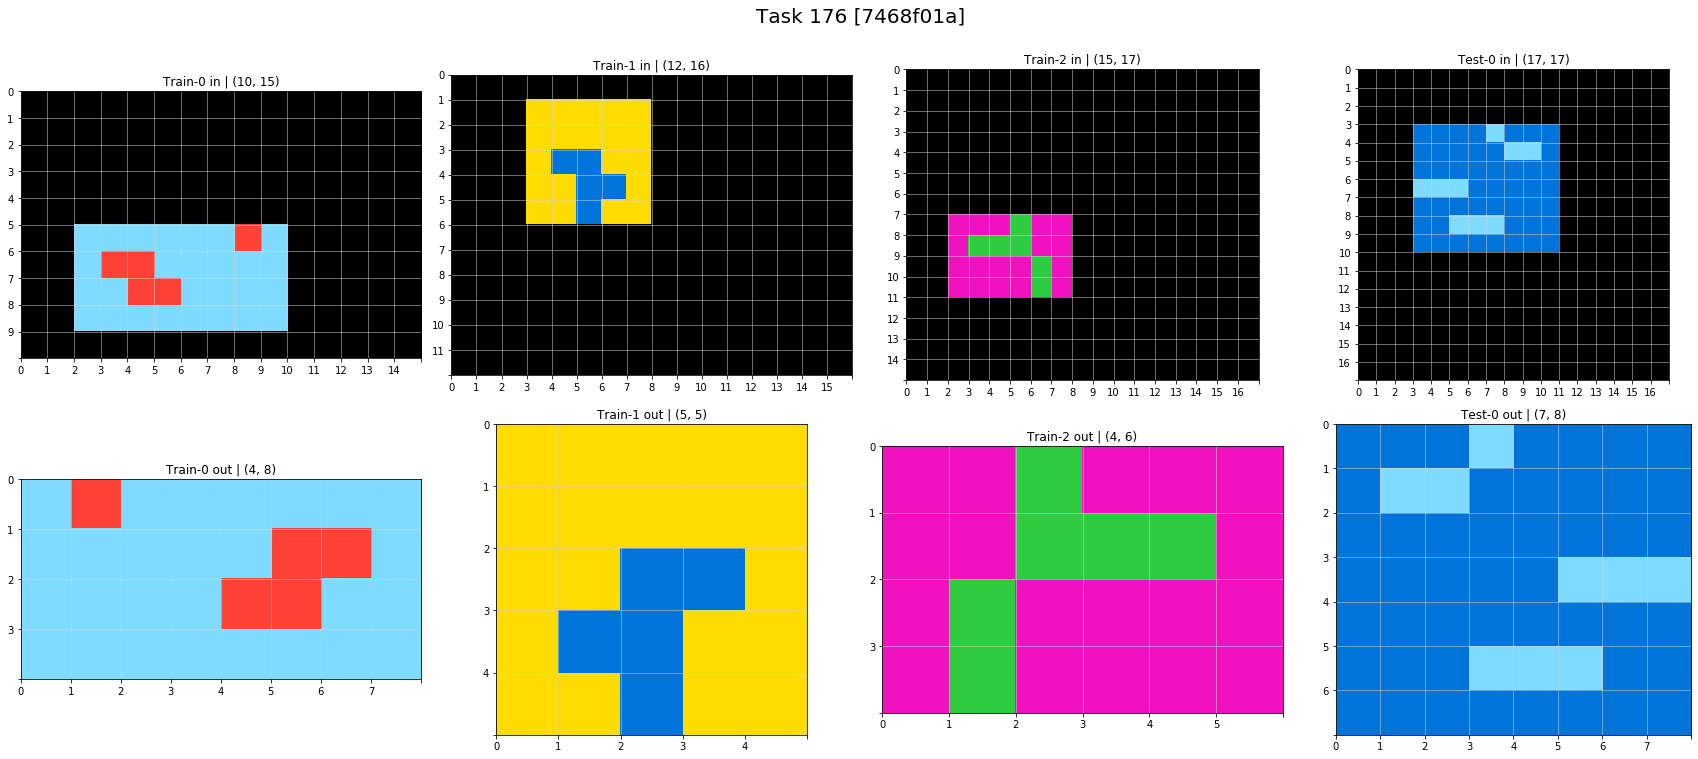

In [27]:
fname = '7468f01a.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid)

In [324]:
def reflect_image(pixmap):
    output = np.flip(pixmap, axis=1)
    return output

In [468]:
task = task['train']

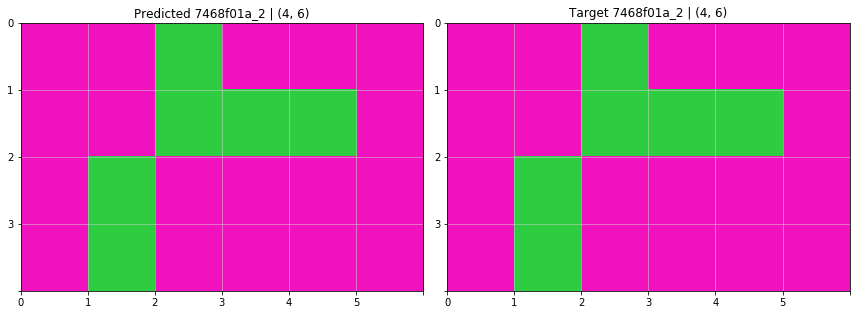

In [333]:
sample_id = 2
pixmap_in, pixmap_out = nth_sample(task, sample_id)
pred = reflect_image(crop_to_content_unlifted(pixmap_in))
plot_pred_and_target(pred, pixmap_out, fname[:-5] + f'_{sample_id}')

# Guessing

## Direction guessing

### Task 117 [746b3537]

#### Insights

- Crop line orthogonal to color direction. For example Train-0 out is a vertical crop, because color direction is horizontal.
- Drop repeated *continguous* colors. 
- This crop pattern is different from previous regarding what is being selected:
  - Previously it was objects surrounded by 0-pixels.
  - In this case, it isn't an object per si (what *is* a object, really?), but its properties.
  - This is easy: if first row has unique colors, color direction is column-wise.

#### Solution

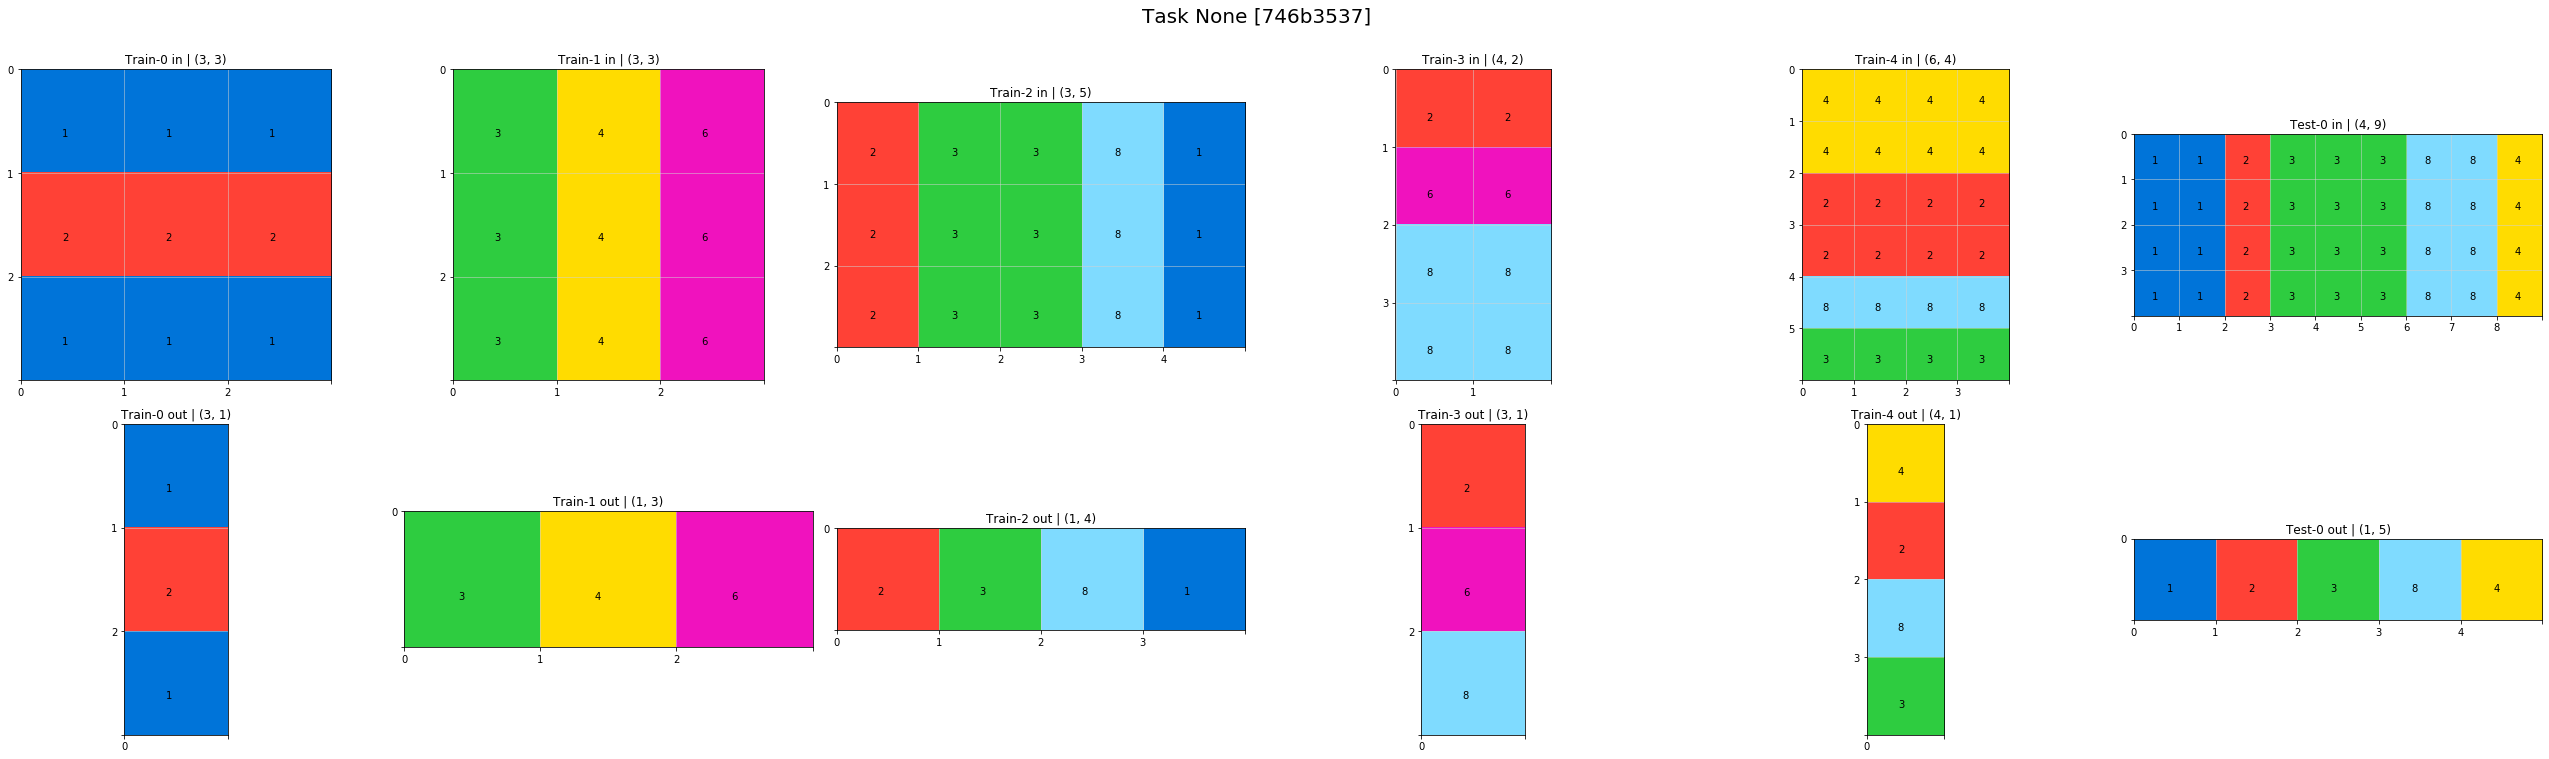

In [28]:
fname = '746b3537.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, annotate=True)

In [453]:
def crop_unique_colors_orthogonal_to_color_continuity(pixmap):
    # select
    row = pixmap[0]
    col = pixmap[:, 0]
    row_uniques = np.unique(row)
    col_uniques = np.unique(col)
    # define return
    return_row = row_uniques.shape[0] != 1
    output = row if return_row else col
    # delete repeated and contiguous elements
    del_idxs = np.nonzero(output[:-1] == output[1:])
    output = np.delete(output, del_idxs)
    # define return shape based on what it will return
    return_shape = (1, -1) if return_row else (-1, 1)
    return output.reshape(*return_shape)

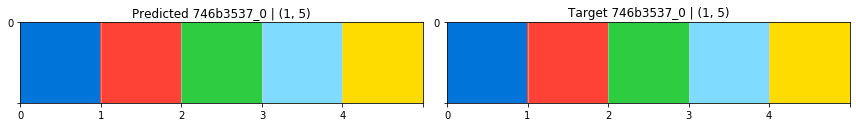

In [465]:
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task['test'], sample_id)
pred = crop_unique_colors_orthogonal_to_color_continuity(pixmap_in)
plot_pred_and_target(pred, pixmap_out, fname, sample_id)

#### Solution with composable functions

- This is the idea. Learn how to compose solutions based on (input, output) pairs.

In [980]:
def unique_colors(pixmap):
    unique = np.unique(pixmap.ravel())
    return unique


def select_row(pixmap):
    i = 0  # can be learned
    row = pixmap[i]
    return row.copy()


def select_col(pixmap):
    i = 0
    col = pixmap[:, i]
    return col.copy()


def unique_rows(pixmap):
    del_rows = np.nonzero((pixmap_in[:-1, :] == pixmap_in[1:, :]).any(axis=1))
    output = np.delete(pixmap, del_rows, axis=0)
    return output


def unique_cols(pixmap):
    del_cols = np.nonzero((pixmap_in[:, :-1] == pixmap_in[:, 1:]).any(axis=0))
    output = np.delete(pixmap, del_cols, axis=0)
    return output


def reshape_to_row(pixmap):
    shape = (1, -1)  # can be learned
    return pixmap.reshape(*shape)


def reshape_to_col(pixmap):
    shape = (-1, 1)  # can be learned
    return pixmap.reshape(*shape)

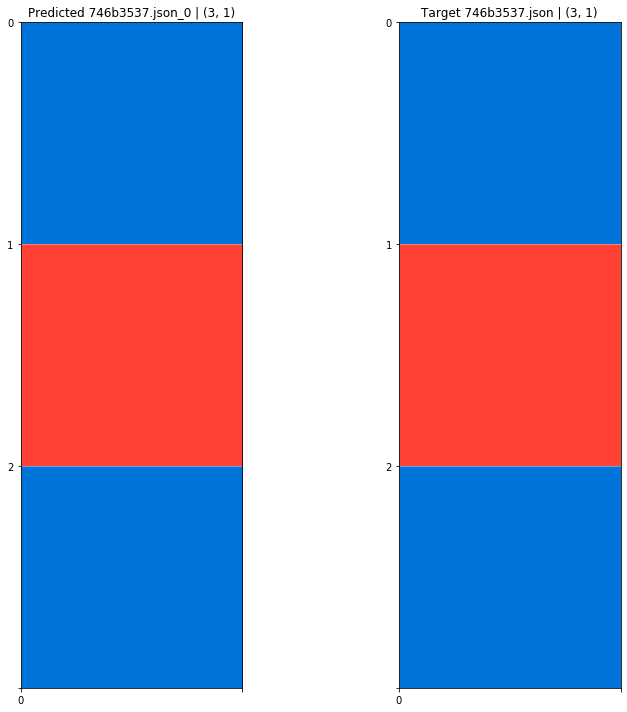

In [981]:
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task['train'], sample_id)
pred = reshape_to_col(unique_rows(select_col(pixmap_in)))
plot_pred_and_target(pred, pixmap_out, fname, sample_id)

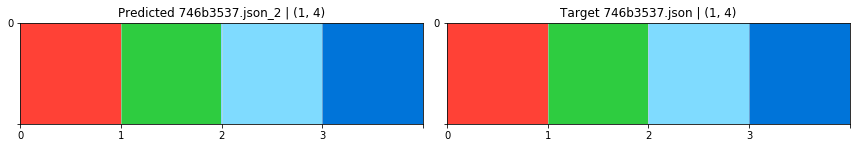

In [983]:
sample_id = 2
pixmap_in, pixmap_out = nth_sample(task['train'], sample_id)
pred = reshape_to_row(unique_cols(select_row(pixmap_in)))
plot_pred_and_target(pred, pixmap_out, fname, sample_id)

## Rectangle guessing

### Task 134 [partially solved; need learning] 

#### Insights

- Is it okay to use the input and output in the method?
  - For the traininig samples, sure. For evaluation and test? Nope. You need to learn the way, padawan.

#### Solution

- Aim to solve way similar to 3.4.3 (746b3537).

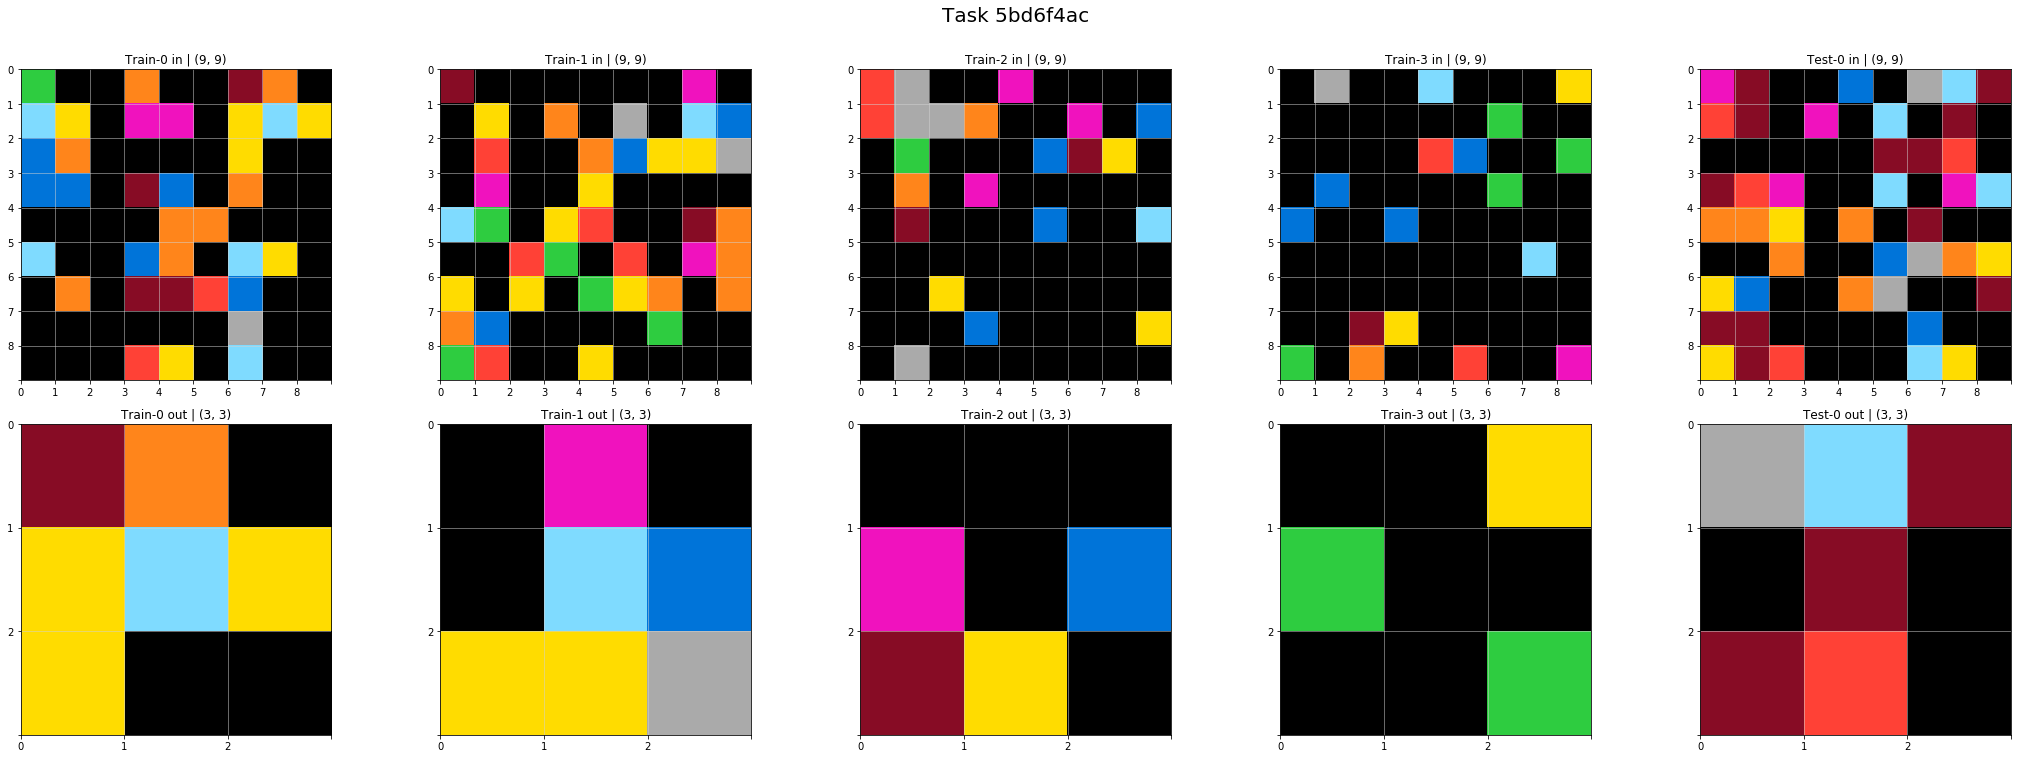

In [996]:
fname = '5bd6f4ac.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2)

In [997]:
task = task['train']
pixmap_in, pixmap_out = nth_sample(task, 0)

In [1062]:
def find_rectangle(pixmap):
    """This function is similar to `fractal_repetition`."""
    pixm_sh = pixmap_in.shape
    xs, ys = np.indices(pixm_sh, dtype=np.int8)

    # must be learned
    rect_sh = (3, 3)

    # generalization of previous definition
    stride = 1  # can be learned
    out_sh = ((pixm_sh[0] - rect_sh[0]) // stride + 1,
              (pixm_sh[1] - rect_sh[1]) // stride + 1)

    shape = out_sh + rect_sh
    strides = (pixm_sh[1],               # bytes to next vertical block
               1,                        # bytes to next horizontal block
               pixm_sh[1],               # bytes to next vertical element
               1)                        # bytes to next horizontal element
    reshape = (out_sh[0] * out_sh[1],) + rect_sh
    xs_strided = as_strided(xs, shape=shape, strides=strides).reshape(*reshape)
    ys_strided = as_strided(ys, shape=shape, strides=strides).reshape(*reshape)
    i = np.random.randint(0, reshape[0])  # must be learned
    return pixmap_in[xs_strided[i], ys_strided[i]].copy()

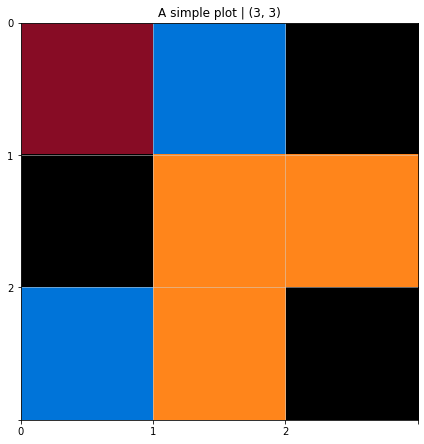

In [1063]:
just_plot(find_rectangle(pixmap_in))

# Find the intruder

## Task 110 [48d8fb45] [unsolved] 

- Aims: crop the *object* *infected* (?) by the intruder.
- Difficulty level: 5/10
- Need better solution.

### Insights

- Solution 1
    - Crop objects and select which has only two colors (foreground, background).
      - Crop by recursion:
        1. Select a random xy-position in the pixmap.
        2. Traces a vertical and a horizontal segments to split the pixmap in 4 subpixmaps, which including the segments.
           - Check if the segments intersect the objects. If there is at least...
    - Remove segment with intruder pixel.
- Solution 2
    - Infect and crop to content. But how dispose the intruder? Store its location.
    - Maybe cellular automata can be useful. In the kaggle there is a kernel trying to solve some problems with it.

### Solution

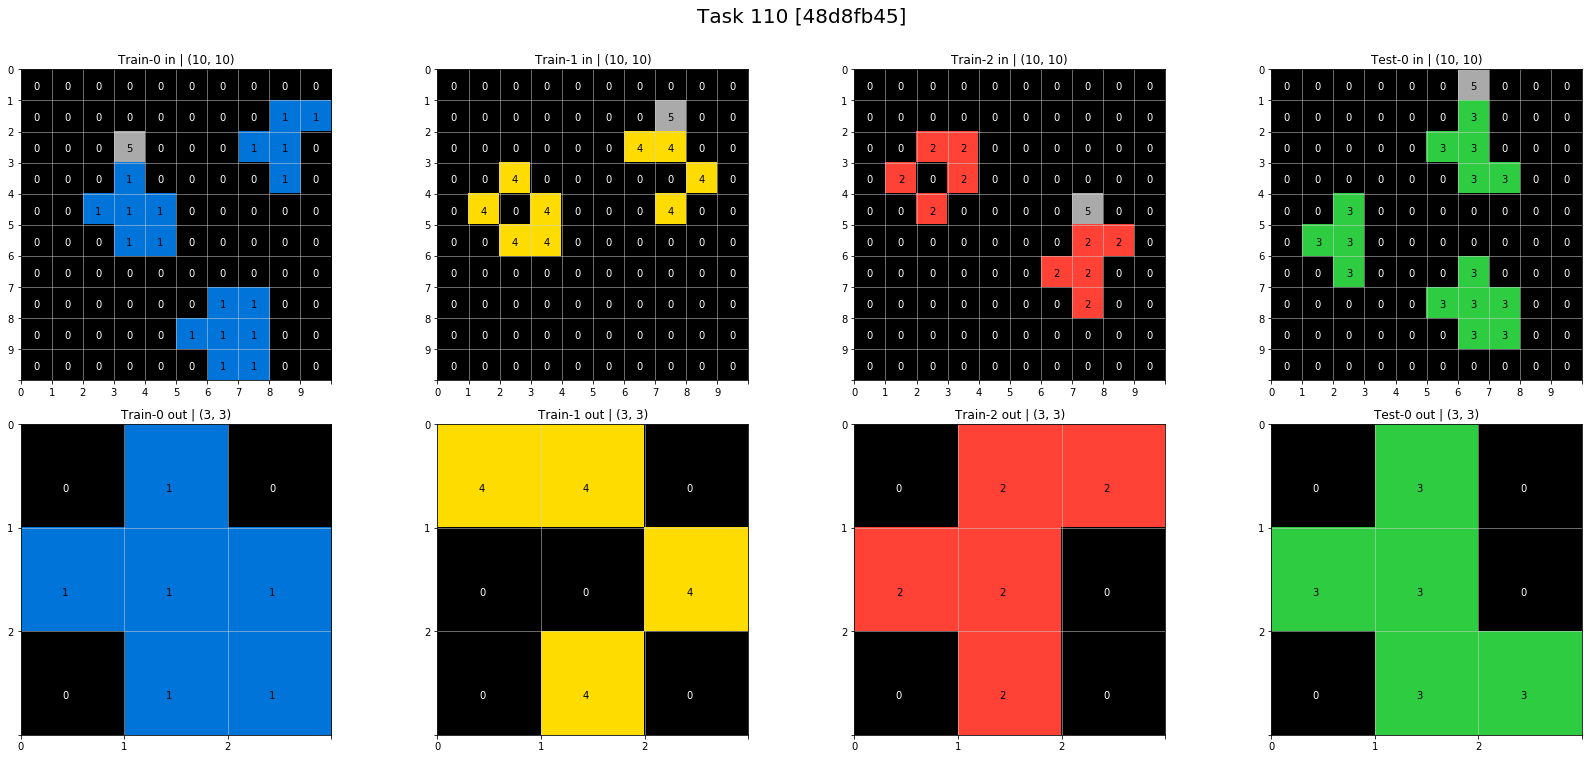

In [30]:
fname = '48d8fb45.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2, annotate=True, task_id=tid)

In [927]:
def infect(pixmap_in):
    pixmap = pixmap_in.copy()
    # count colors frequency
    count = np.bincount(pixmap.ravel())
    # find intruder location
    intruder = np.argmax(count == np.trim_zeros(np.sort(count))[0])
    intruder_coords = np.argwhere(pixmap == intruder)
    # find dominant color (ASSUMPTION: the intruder will be the least dominant, aside from the foreground)
    dominant = np.argmax(count == np.sort(count)[-2])
    # infect
    xs, ys = np.indices((3, 3))
    dx, dy = (intruder_coords - 1).reshape(-1,)
    while True:  # this may be not a good idea in the GP algorithm
        # center in a 3x3 block in intruder_location
        block = pixmap[xs + dx, ys + dy]
        # next one to infect
        coords = zip(*np.nonzero(block == dominant))
        try:
            next_x, next_y = next(coords)  # need only the first coord here (infect one per block, horizontally)
        except StopIteration:
            break  # this means that there is not more pixels to be infected
        # (dx, dy) is a vector from (0, 0) in pixmap to block (0, 0)
        # (next_x, next_y) is a vector from (0, 0) in block to where next_to_infect is
        coords = (next_x + dx, next_y + dy)
        pixmap[coords] = intruder
        # next block will center in this infected pixel
        dx, dy = coords  # coords in the block center
        dx, dy = dx - 1, dy - 1  # displacement to origin (0, 0)

    # rationale? just to solve; need to eval in other similar cases.
    x, y = intruder_coords[0]
    pixmap[x, y] = 0  # FIXME?: this maybe won't generalize to other similar cases

    return pixmap


In [928]:
def normalize_color_by_dominant(pixmap_in):
    pixmap = pixmap_in.copy()
    count = np.bincount(pixmap.ravel())
    dominant = np.argmax(count == np.sort(count)[-2])
    weak = np.argmax(count == np.trim_zeros(np.sort(count))[0])
    weak_idxs = np.nonzero(np.logical_and(pixmap == weak, pixmap != 0))
    pixmap[weak_idxs] = dominant
    return pixmap

In [934]:
sample_id = 2
pixmap_in, pixmap_out = nth_sample(task['train'], sample_id)

## Task 35 [partially solved; need learning]

- Patterns: crop, find the intruder.
- Aims: crop the non-intruder *object*.

### Insights

- Group by color, crop by content.
  - Assumptions: intruders has different colors from the target object.

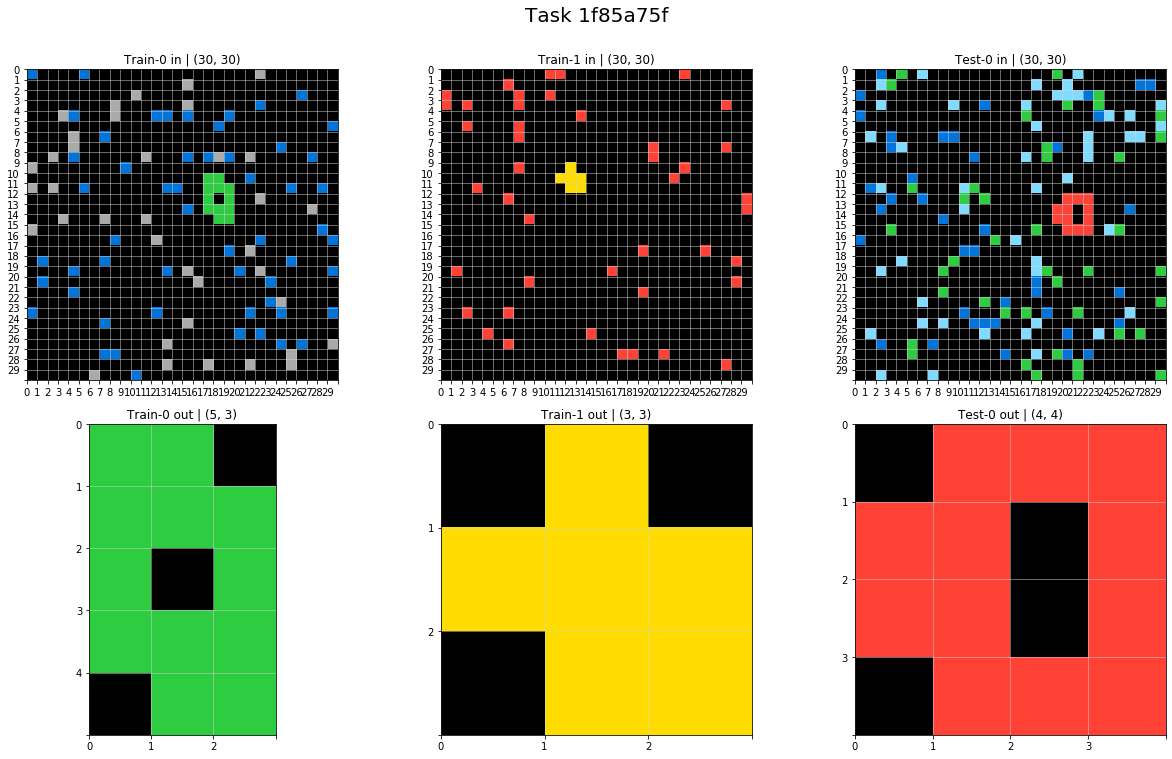

In [1139]:
fname = '1f85a75f.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2)

In [1140]:
sample_id = 0
pixmap_in, pixmap_out = nth_sample(task['train'], sample_id)

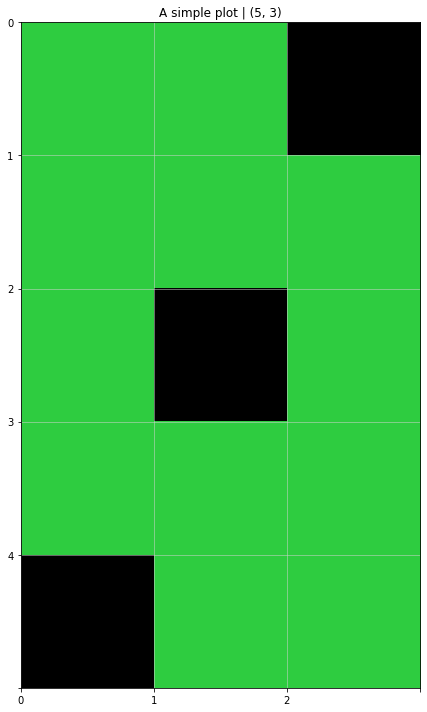

In [1145]:
pred = group_by_color_unlifted(pixmap_in)
just_plot(crop_to_content_unlifted(pred[-2]))

# Deconstruction

## Task 38 [partialy solved; need learning]

- Patterns: crop, pattern_deconstruction.

### Solution

- Solution 1
    - Crop to content, then guess rectangle.
- Solution 2
    - Crop to content, then break in four parts. The solution must be learned.

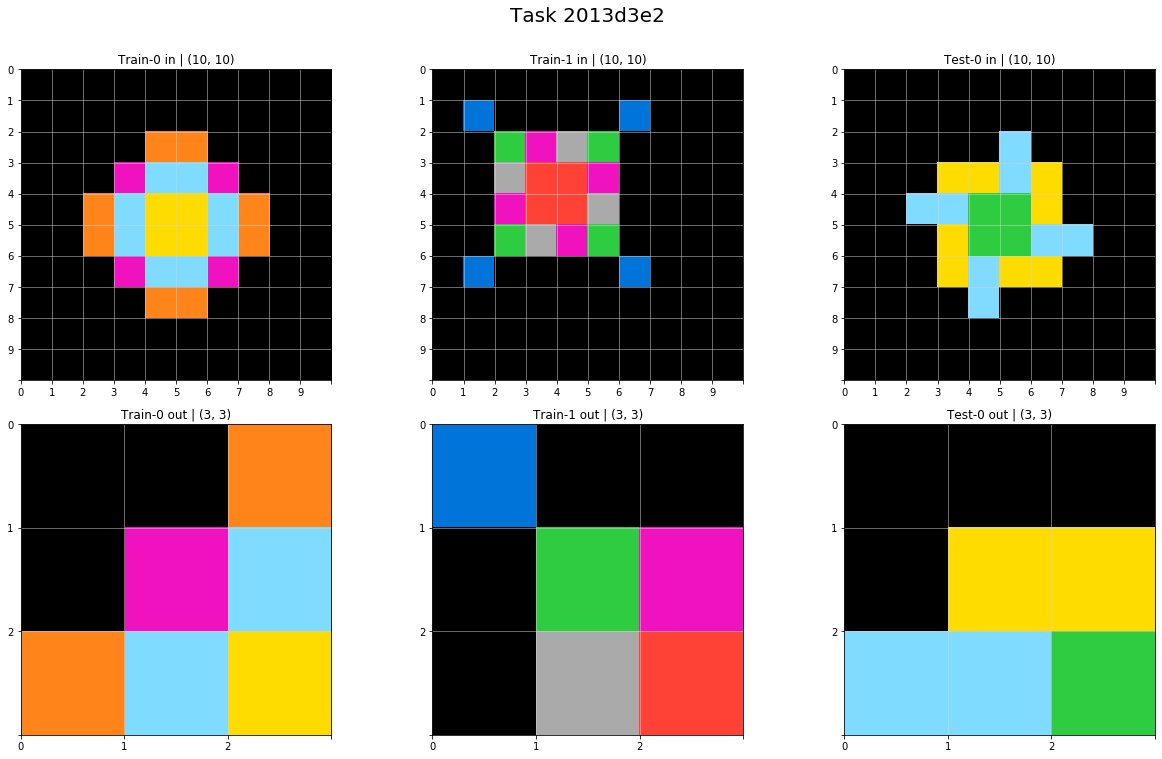

In [1108]:
fname = '2013d3e2.json'
tid = training_tasks.index(fname)
task = load_and_plot(training_path, training_tasks[tid], return_what=2)

In [1109]:
task = task['train']

In [1110]:
pixmap_in, pixmap_out = nth_sample(task, 0)

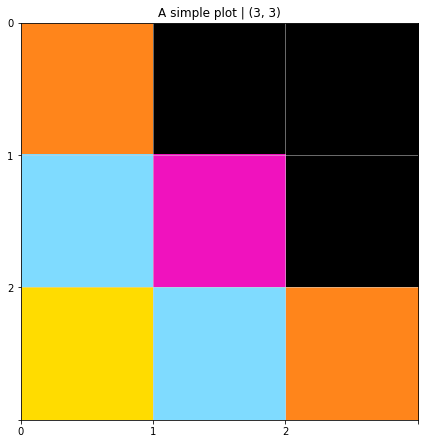

In [1111]:
just_plot(find_rectangle(crop_to_content_unlifted(pixmap_in)))

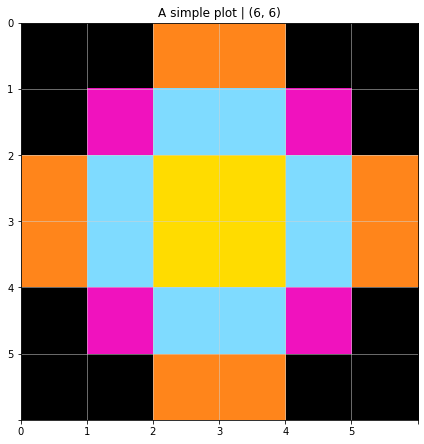

In [1129]:
pred = crop_to_content_unlifted(pixmap_in)
just_plot(pred)

In [1130]:
def retrieve_quadrants(pixmap):
    """
    This function is similar to `fractal_repetition`.
    NOTE: reusing the function AGAIN.

    I just modified the `stride`, the `out_sh` name,
    and the second component of `strides.
    """
    pixm_sh = pixmap.shape
    xs, ys = np.indices(pixm_sh, dtype=np.int8)

    # must be learned
    rect_sh = (3, 3)

    # generalization of previous definition
    stride = 3  # can be learned
    blks_sh = ((pixm_sh[0] - rect_sh[0]) // stride + 1,
              (pixm_sh[1] - rect_sh[1]) // stride + 1)

    shape = blks_sh + rect_sh
    strides = (pixm_sh[1] * stride,      # bytes to next vertical block
               stride,                   # bytes to next horizontal block
               pixm_sh[1],               # bytes to next vertical element
               1)                        # bytes to next horizontal element
    reshape = (blks_sh[0] * blks_sh[1],) + rect_sh
    xs_strided = as_strided(xs, shape=shape, strides=strides).reshape(*reshape)
    ys_strided = as_strided(ys, shape=shape, strides=strides).reshape(*reshape)
    i = np.random.randint(0, reshape[0])  # must be learned
    return pixmap[xs_strided[i], ys_strided[i]].copy()

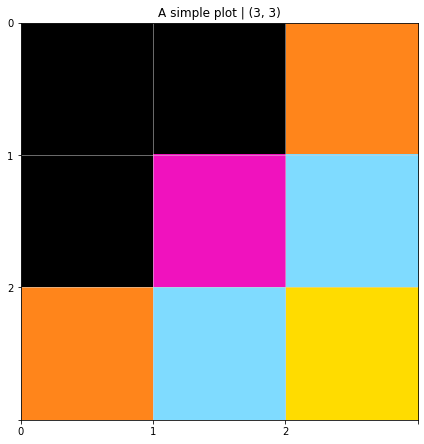

In [1138]:
just_plot(retrieve_quadrants(pred))

# Enclosure

## Task 28 [1c786137] [partially solved]

- Patterns: crop, detect_enclosure.

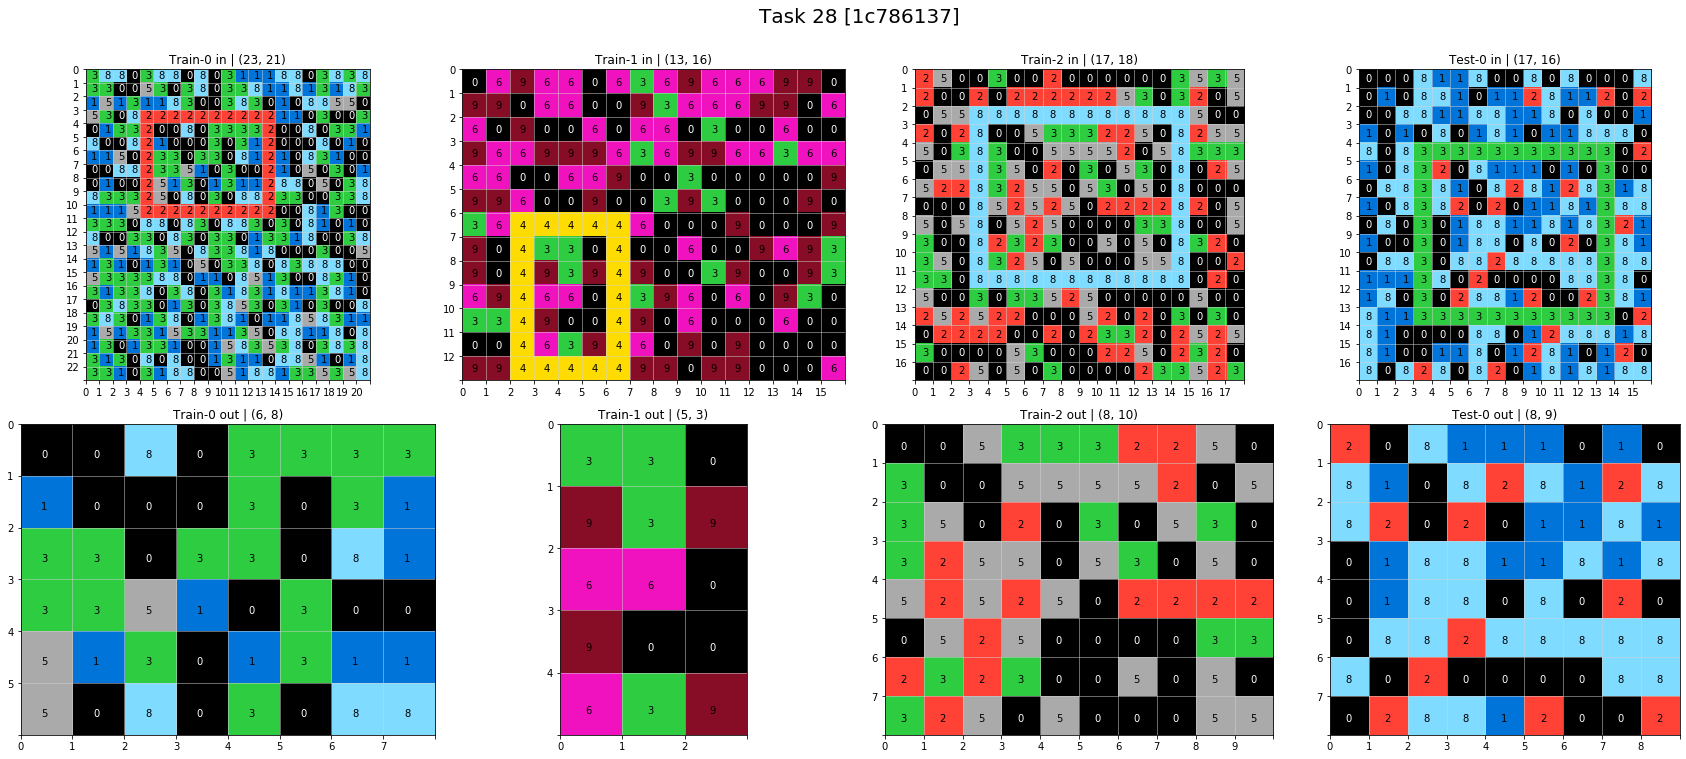

In [376]:
fname = '1c786137.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, annotate=True)

In [513]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage import measure

def filter_by_corners(pixmap):
    outputs = []
    groups = group_by_color_unlifted(pixmap_in)
    for group in groups:
        # can't detect > 2 corners in small rectangles
        # maybe peak_local_max?
        coords = corner_peaks(corner_harris(group), min_distance=1)
        if len(coords) <= 4:
            outputs.append(group)
    return outputs


def extract_closure_from_rect(pixmap):
    # coords = corner_peaks(corner_harris(pixmap), min_distance=1)
    # seems like coords are already ordered
    # ind = np.lexsort((coords[:, 1], coords[:, 0]))
    # coords = coords[ind]
    # ul, ur, ll, lr = coords

    # coords by contours
    coords = measure.find_contours(pixmap, level=0, positive_orientation='high')[1].astype(np.int8)  # inside
    walk = sum(coords[:-1, 0] == coords[0][0]) - 1
    ll = coords[walk]  # walk from lower right to lower left
    walk += sum(coords[:-1, 1] == ll[1]) - 1
    ul = coords[walk]  # walk to upper left
    walk += sum(coords[:-1, 0] == ul[0]) - 1
    ur = coords[walk]  # walk to upper right
    return pixmap[ul[0]:ll[0] + 1, ul[1]:ur[1] + 1]

In [514]:
task = task_dict['train']

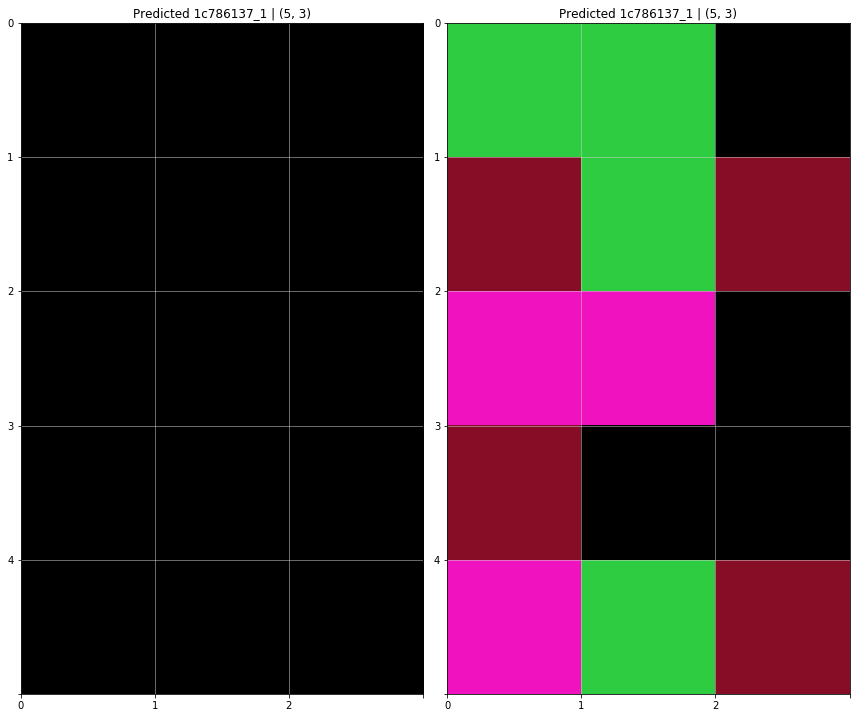

In [521]:
sample_id = 1
pixmap_in, pixmap_out = nth_sample(task, sample_id)
filtered = filter_by_corners(pixmap_in)
pred = extract_closure_from_rect(filtered[0])
plot_pred_and_target(pred, pixmap_out, fname, sample_id)

# Jigsaw Puzzle

## Pattern juxtaposition / transform / moving 

### Task 232 [incomplete]

- Difficulty: 8/10

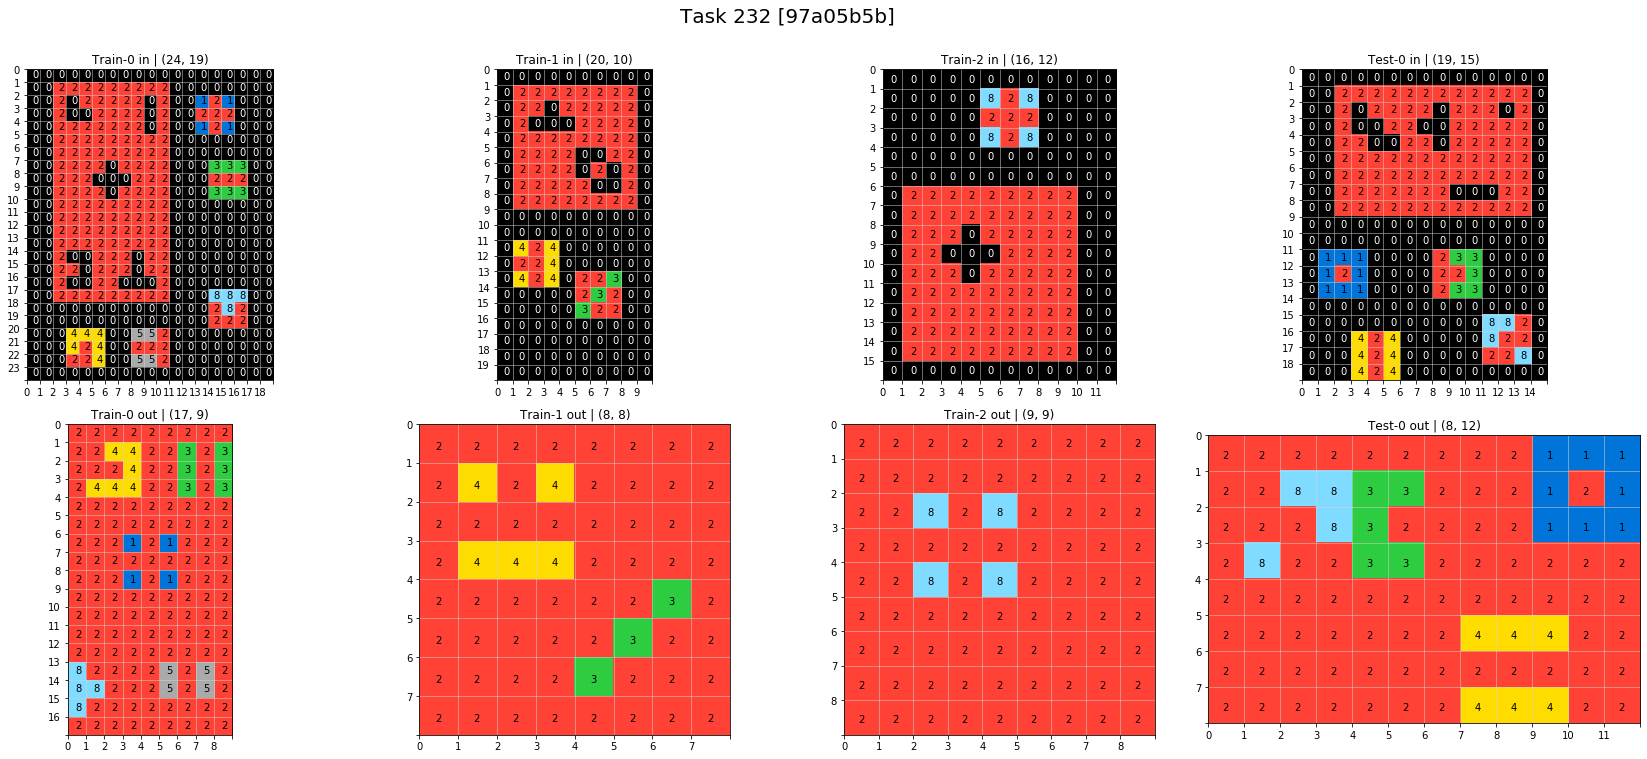

In [522]:
fname = '97a05b5b.json'
tid = training_tasks.index(fname)
task_dict = load_and_plot(training_path, training_tasks[tid], return_what=2, task_id=tid, annotate=True)

In [671]:
def retrieve_objects(pixmap):
    """
    This function is similar to `retrieve_rectangles`.

    I just modified the to filter rectangles.
    """
    pixm_sh = pixmap.shape
    xs, ys = np.indices(pixm_sh, dtype=np.int8)

    # must be learned
    rect_sh = (3, 3)

    # generalization of previous definition
    stride = 1  # can be learned
    blks_sh = ((pixm_sh[0] - rect_sh[0]) // stride + 1,
              (pixm_sh[1] - rect_sh[1]) // stride + 1)

    shape = blks_sh + rect_sh
    strides = (pixm_sh[1] * stride,      # bytes to next vertical block
               stride,                   # bytes to next horizontal block
               pixm_sh[1],               # bytes to next vertical element
               1)                        # bytes to next horizontal element
    reshape = (blks_sh[0] * blks_sh[1],) + rect_sh
    xs_strided = as_strided(xs, shape=shape, strides=strides).reshape(*reshape)
    ys_strided = as_strided(ys, shape=shape, strides=strides).reshape(*reshape)
    i = np.random.randint(0, reshape[0])  # must be learned

    outputs = []
    for i in range(reshape[0]):
        rect = pixmap[xs_strided[i], ys_strided[i]]
        uniques_in_rect = np.unique(rect)
        if uniques_in_rect.size == 2 and 0 not in uniques_in_rect:
            outputs.append(rect.copy())
    return outputs

In [906]:
def extract_closure_from_rect(pixmap):
    """
    Version 2:
        Changes: extract closure from full pixmap.
    """
    # coords by contours
    contours = measure.find_contours(pixmap, level=0)
    # get longer contour
    contours_size = np.array([c.size for c in contours])
    coords = contours[np.argmax(contours_size)].astype(np.int8)
    # walk to extract points
    walk = sum(coords[:-1, 0] == coords[0][0]) - 1
    ll = coords[walk]  # walk from lower right to lower left
    ll[1] -= 1
    walk += sum(coords[:-1, 1] == ll[1]) - 1
    ul = coords[walk]  # walk to upper left
    ul[0] -= 1
    walk += sum(coords[:-1, 0] == ul[0]) - 1
    ur = coords[walk]  # walk to upper right
    ur[1] += 1
    ll += (-1, 1)
    ul += (1, 1)
    ur += (1, -1)
    # return closure
    return pixmap[ul[0]:ll[0] + 1, ul[1]:ur[1] + 1].copy()

In [1322]:
def match_and_fit_patterns(pixmap):

    def mask_obj(obj, main_color, secondary_color, ret_nd_color=True):
        mask = obj == main_color
        flip_mask = np.logical_not(mask)
        obj[mask] = secondary_color
        non_dominant = obj[flip_mask][0]
        obj[flip_mask] = main_color
        if ret_nd_color:
            return obj, non_dominant
        return obj

    def match_coords(pixmap, obj):
        result = feature.match_template(pixmap, obj)
        ij = np.unravel_index(np.argpartition(result.ravel(), -3)[-3:], result.shape)  # first peak => its 2D index
        max_res = np.round(result[ij], decimals=3) == 1.
        return ij[0][max_res], ij[1][max_res]

    def pixels_around(pixmap, x, y, s, c):
        if x > 0 and y > 0:
            x, y = x - 1, y - 1
        elif x > 0:
            x, y = x - 1, y
        elif y > 0:
            x, y = x, y - 1
        return (pixmap[x:x + s, y:y + s] == background).any()

    k = 3  # rect shape
    main_color = 2  # can be learned
    background = 0  # can be learned?
    objects = retrieve_objects(pixmap)  # could pass shape = (3, 3) here...
    masked_objs = [mask_obj(obj, main_color, background) for obj in objects]
    extracted_pixmap = extract_closure_from_rect(pixmap)

    for obj, nd_color in masked_objs:
        rotated_objs = [np.rot90(obj, k=i + 1).copy() for i in range(4)]
        for robj in rotated_objs:
            # possible matches
            xs, ys = match_coords(extracted_pixmap, robj)
            for x, y in zip(xs, ys):
                # extract matched part
                part = extracted_pixmap[x:x + k, y:y + k].copy()
                # unmask: retrieve obj original colors
                unmasked_obj = mask_obj(robj, main_color, nd_color, ret_nd_color=False)
                # check if match part wasn't replaced before
                if (part == background).any():
                    extracted_pixmap[x:x + k, y:y + k] = unmasked_obj
                # check if there are colors other 0s around
                if pixels_around(extracted_pixmap, x, y, k, background):
                    extracted_pixmap[x:x + k, y:y + k] = part

    return extracted_pixmap

In [524]:
task = task_dict['train']

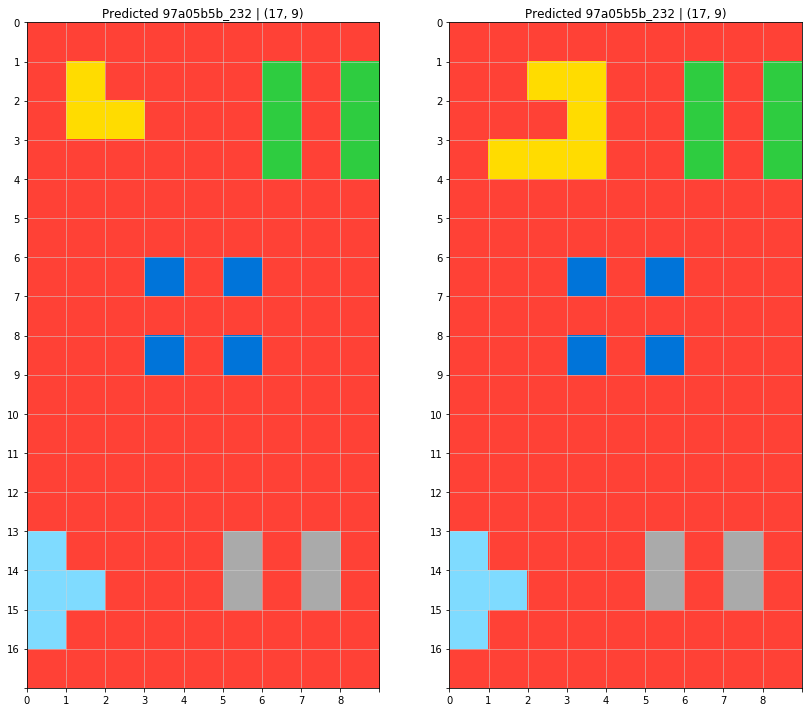

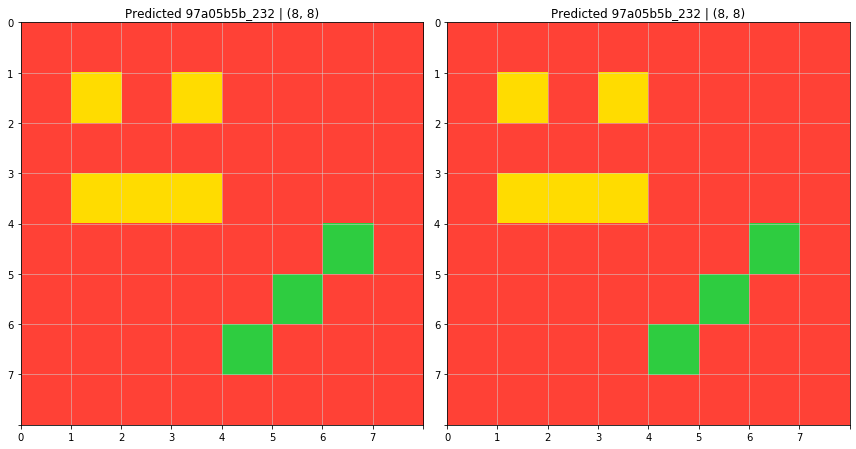

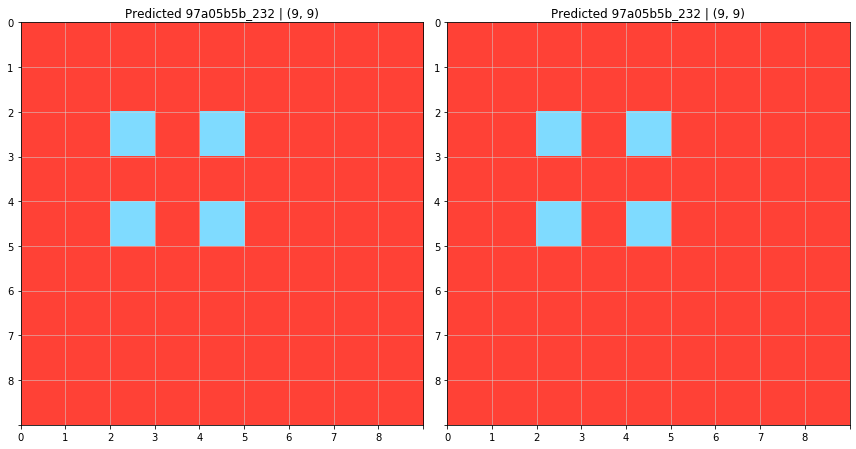

In [1334]:
for sample_id in range(len(task)):
    pixmap_in, pixmap_out = nth_sample(task, sample_id)
    pred = match_and_fit_patterns(pixmap_in)
    plot_pred_and_target(pred, pixmap_out, fname, tid)

In [1335]:
task = task_dict['test']

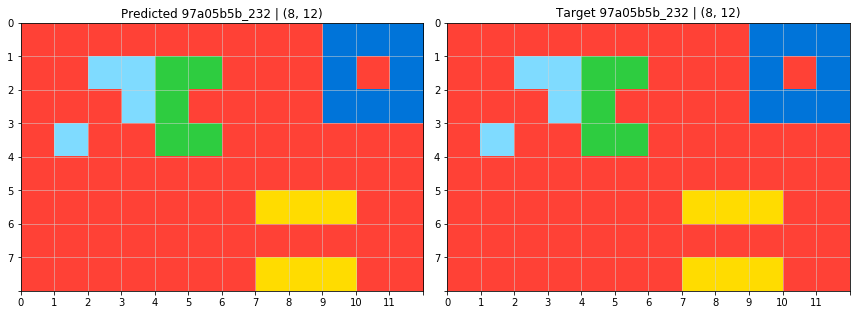

In [1336]:
for sample_id in range(len(task)):
    pixmap_in, pixmap_out = nth_sample(task, sample_id)
    pred = match_and_fit_patterns(pixmap_in)
    plot_pred_and_target(pred, pixmap_out, fname, tid)